# Import lots of stuff

In [11]:
import sys
sys.path.append('../')

In [18]:
import math
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import nlp_utils as utils
from nltk import bigrams
from collections import Counter
from pycorenlp import StanfordCoreNLP
%matplotlib inline
pd.set_option('display.max_rows', 500)

### TODO
1. convert from nltk to spacy to reduce dependencies on stanford CoreNLP

# Preprocess data for analyses

## Import annotated file

In [15]:
d_raw = pd.read_csv('../../data/tangramsSequential.csv')
d = d_raw.copy()

# Result 1: Generate file for POS analysis

## Start the Stanford CoreNLP server

Before running this notebook, [get CoreNLP](http://nlp.stanford.edu/software/stanford-corenlp-full-2015-12-09.zip), go into its directory, and run

`java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer 9000`

If you're using port 9000 for something else, change that value and then change `PORT` in the next cell.

In [16]:
PORT = 9000
nlp = StanfordCoreNLP('http://localhost:{}'.format(PORT))

## Get part of speech

In [19]:
# A lemma is a (word, pos) tag pair.
d['lemmas'] = [utils.stanford_pos(text) for text in d['contents']]

Hello, I am going to describe them as people almost.: cannot parse
Is that okay?: cannot parse
yes: cannot parse
This one kinda looks like they are looking a little down and kneeling with both arms out: cannot parse
wearing a dress maybe.: cannot parse
Good job1 This one is sitting down: cannot parse
iwth his knees up: cannot parse
This one looks like a ghost almost: cannot parse
with his arms raised up: cannot parse
This one looks like he is balancing on one leg wit hhis arms out: cannot parse
This one looks like a woman in a dress who is throwing her head back: cannot parse
and walking with her hand up: cannot parse
This one looks like a preacher holding a book and standing straight: cannot parse
This one has bunny ears: cannot parse
This one looks like the preacher except he is bending his knees: cannot parse
bending them back?: cannot parse
bending or kneeling: cannot parse
Hmm he is facing right: cannot parse
bending not kneeling: cannot parse
This one looks like a man with a bloc

In [15]:
d['tokens'] = [[element[0] for element in l] for l in d['lemmas']]
d['pos'] = [[element[1] for element in l] for l in d['lemmas']]

In [16]:
d['numWords'] = [pd.value_counts(words).sum() for words in d['tokens']]

In [23]:
d['parse'] = [[w for w in utils.stanford_parsetree(text)] for text in d['contents']]

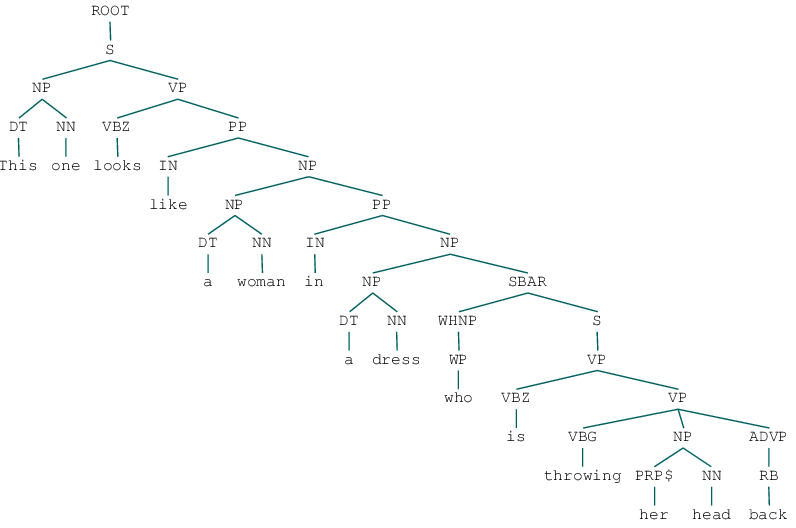

In [92]:
Tree.fromstring(d['parse'][10][0])

In [94]:
d['num_sbar'] = [utils.sbar_count(parse[0]) for parse in d['parse']]
d['num_pp'] = [utils.pp_count(parse[0]) for parse in d['parse']]
d['num_cc'] = [utils.cc_count(parse[0]) for parse in d['parse']]

## Get counts for each POS label

In [95]:
d['nouns'] = [sum([1 if utils.is_noun(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['prepositions'] = [sum([1 if utils.is_prep(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['verbs'] = [sum([1 if utils.is_verb(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['determiners'] = [sum([1 if utils.is_det(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['pronouns'] = [sum([1 if utils.is_pronoun(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['adjectives'] = [sum([1 if utils.is_adjective(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['adverbs'] = [sum([1 if utils.is_adverb(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['numbers'] = [sum([1 if utils.is_num(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]
d['others'] = [sum([1 if utils.is_other(*lem) else 0 for lem in lemmas])
                     for lemmas in d['lemmas']]

In [96]:
d.columns

Index(['gameid', 'msgTime', 'roundNum', 'occurrenceNum', 'role',
       'intendedName', 'timeElapsed', 'contents', 'totalLength', 'thinksHuman',
       'comments', 'ratePartner', 'score', 'nativeEnglish', 'workerid_uniq',
       'time', 'intendedObj', 'clickedObj', 'objBox', 'correct', 'numRawWords',
       'lemmas', 'tokens', 'pos', 'numWords', 'parse', 'nouns', 'prepositions',
       'verbs', 'determiners', 'pronouns', 'adjectives', 'adverbs', 'numbers',
       'others', 'num_sbar', 'num_pp', 'num_cc'],
      dtype='object')

## Export to csv for plotting in R

In [97]:
(d.drop(["lemmas", "tokens"], 1)
 .to_csv("sequential_posTagged.csv", index = False))

# Result 2: Calculate indicator words for tangrams/rounds

## First, get list of words in first round

In [17]:
# Filter down to first round
d_round1 = d[d['occurrenceNum'] == 1]

# Pull out all tokens and collapse into count dict
tokenDict = Counter([item for sublist in d_round1['tokens'].tolist()
                     for item in sublist])
# Pull out all words that occur more than once
wordList = [word for (word,count) in tokenDict.items() if count > 1 and not word.isdigit()]
print(wordList[0:10])
print(len(wordList))

# Get POS map; will be longer because it doesn't require count > 1, but it doesn't matter
POSdict = {word: POS for lemma in d_round1['lemmas'] for (word, POS) in lemma}
print(len(POSdict.keys()))

['Hello', ',', 'I', 'am', 'going', 'to', 'describe', 'them', 'as', 'people']
870
1776


## Get list of all game ids

In [18]:
gameidList = pd.unique(d.gameid.ravel()).tolist()
print(gameidList[0:5])
print(len(gameidList))

['7026-d36b3d5a-1ba3-403c-bcbd-31d0d1a0aa6b', '1567-e80221b4-f349-4b3b-9921-224ee47eea1f', '1670-7a1fc24b-6599-4efb-8a98-22ce7368261a', '5108-ab2d0b72-034a-4f00-991a-416faf93c98c', '3419-7061f84e-30ba-48dc-9bc3-133c5fdf8fa3']
87


## Get list of all tangram names

In [19]:
tangramList = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
print(tangramList)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']


## Helper functions to select words & counts

In [20]:
def getWordCounts(df, gameid, occurrenceNum, tangram = None) :
    roundCond = 'occurrenceNum == ' + occurrenceNum
    gameidCond = 'gameid == "' + gameid + '"'
    if(tangram is not None) :
        tangramCond = 'intendedObj == "' + tangram + '"'
        cond = " and ".join((roundCond, gameidCond, tangramCond))
    else :
        cond = " and ".join((roundCond, gameidCond))
    relevantRow = df.query(cond)
    return Counter([item for sublist in relevantRow['tokens'].tolist() 
                    for item in sublist])

#creates mini dataframe that grabs the words used in round n for a given tangram and gameid
def selectTangramRoundWords(df, tangram, roundNum, gameid):
    wordCounts = getWordCounts(df, gameid, roundNum, tangram)
    return list(wordCounts.keys())

## Helper function to compute PMIs

Note that merging is really costly -- if we need to speed it up, this might be the first target. Can also vectorize the log operation.

In [21]:
#returns a table with the all words above 0 PMI and their counts for a given tangram
#calculate the probability for words given tangram A ------ p(x|y)
def makeMyPMI(df, tangram, roundNum, gameid, totals):

    # count words w/in tangram
    tangramCounts = getWordCounts(df, gameid, roundNum, tangram)

    #total number of words 
    tangramNumWords = (1 if sum(tangramCounts.values()) == 0 
                       else sum(tangramCounts.values()))

    #dataframe to compare 
    indicatorDF = pd.merge(pd.DataFrame(list(tangramCounts.items()), columns=['word', 'count']),
                           pd.DataFrame(list(totals["counts"].items()), columns=['word', 'totalCount']),
                           on='word', how = 'inner')

    #calculate PMI without log first. Having trouble with float issues. 
    indicatorDF['roughPMI'] = ((indicatorDF['count']/tangramNumWords)
                                / (indicatorDF['totalCount']/totals["numWords"]))
    indicatorDF['logPMI'] = [math.log10(num) for num in indicatorDF['roughPMI']]
    
    #remove column rough PMI
    indicatorDF = indicatorDF.drop('roughPMI', 1)
    
    return indicatorDF

## Write out PMIs & matching rates for all words

Note that we do a sloppy optimization by only computing total counts once and only when necessary 

In [111]:
def memoize(d, gameid, counts) : 
    if "counts" not in counts : 
        counts["counts"] = getWordCounts(d, gameid, "1")
        counts["numWords"] = float(sum(counts["counts"].values()))
        return counts
    else :
        return counts

with open('sequential_matchAndPMI.csv', 'a', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['word', 'POS', 'match', 'pmi', 'total'])
    for word in wordList :
        print(word + ":" + POSdict[word])
        pmi = 0
        match = 0
        total = 0
        for gameid in gameidList:  
            memoizedCounts = {}
            for tangram in tangramList:
                memoizedCounts = memoize(d, gameid, memoizedCounts)
                round1WordList = selectTangramRoundWords(d, tangram, "1", gameid)
                total = total + 1 if word in round1WordList else total
                if word in round1WordList :
                    PMI_df = makeMyPMI(d, tangram, "1", gameid, memoizedCounts)
                    pmi = pmi + PMI_df[PMI_df['word'] == word]['logPMI'].tolist()[0]
                    round6WordList = selectTangramRoundWords(d, tangram, "6", gameid)
                    match = (match + 1 if (word in round1WordList and word in round6WordList)
                             else match)
        writer.writerow([word, POSdict[word], float(match) / float(total), pmi/total, total])


Hello:UH
,:,
I:PRP
am:VBP
going:VBG
to:TO
describe:VB
them:PRP
as:IN
people:NNS
almost:RB
.:.
Is:VBZ
that:WDT
okay:JJ
?:.
yes:RB
This:DT
one:CD
kinda:NN
looks:VBZ
like:IN
they:PRP
are:VBP
looking:VBG
a:DT
little:JJ
down:RP
and:CC
kneeling:VBG
with:IN
both:DT
arms:NNS
out:RP
wearing:VBG
dress:NN
maybe:RB
Good:JJ
is:VBZ
sitting:VBG
his:PRP$
knees:NNS
up:RP
ghost:NN
raised:VBN
he:PRP
balancing:VBG
on:IN
leg:NN
woman:NN
in:IN
who:WP
her:PRP$
head:NN
back:RB
walking:VBG
hand:NN
preacher:NN
holding:VBG
book:NN
standing:VBG
straight:JJ
has:VBZ
bunny:NN
ears:NNS
the:DT
except:IN
bending:VBG
or:CC
Hmm:NN
facing:VBG
right:NN
not:RB
man:NN
block:NN
hes:NNS
smaller:JJR
kid:NN
arm:NN
chest:NN
pointy:JJ
part:NN
person:NN
their:PRP$
hood:NN
hmm:NN
knee:NN
small:JJ
but:CC
no:DT
Hi:NN
sad:JJ
kicking:VBG
hello:UH
:::
-RRB-:-RRB-
sideways:RB
east:JJ
praying:VBG
dancing:NN
high:JJ
dance:NN
air:NN
bottom:NN
last:JJ
you:PRP
just:RB
picked:VBD
triangle:NN
shaped:JJ
diamond:NN
middle:NN
of:IN
line:NN
look:VB


Also write out raw word counts on each round (so we can see what most likely words to be dropped are).

In [23]:
for row in d :
    print row

gameid
roundNum
sender
contents
tangramRef
lemmas
tokens
pos
numWords
nouns
prepositions
verbs
determiners
pronouns
adjectives
adverbs
numbers
others


## Compute unigrams and bigrams

In [44]:
d['bigrams'] = [list(bigrams(l)) for l in d['tokens']]
bigramDict = Counter([item for sublist in d['bigrams'].tolist()
                     for item in sublist])
bigramList = [bigram for (bigram,count) in bigramDict.items() if count > 5]

In [45]:
def getBigramCounts(df, gameid, roundNum, tangram = None) :
    roundCond = 'roundNum == ' + roundNum
    gameidCond = 'gameid == "' + gameid + '"'
    if(tangram is not None) :
        tangramCond = 'tangramRef == "' + tangram + '"'
        cond = " and ".join((roundCond, gameidCond, tangramCond))
    else :
        cond = " and ".join((roundCond, gameidCond))
    relevantRow = df.query(cond)
    return Counter([item for sublist in relevantRow['bigrams'].tolist() 
                    for item in sublist])

with open('bigramCounts.csv', 'a') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['gameid', 'roundNum', 'word', 'count'])
    for gameid in gameidList:  
        for roundNum in ['1', '2', '3', '4', '5', '6'] :
            counts = getBigramCounts(d, gameid, roundNum)
            for bigram in bigramList :
                writer.writerow([gameid, roundNum, ' '.join(bigram), counts[bigram]])

In [ ]:
## bootstrap analysis (might want to move to R)

TODO: exclude numbers earlier in the pipeline, 

TODO: don't average over matches and pmis

In [22]:
numSamples = 1000

#grab words with highestPMI for a given tangram/gameid
def highestPMIWords(d, tangram, roundNum, gameid):
    allTangramCounts = {}
    allTangramCounts['counts'] = getWordCounts(d, gameid, "1")
    allTangramCounts['numWords'] = float(sum(allTangramCounts["counts"].values()))

    PMIdf = (makeMyPMI(d, tangram, roundNum, gameid, allTangramCounts))

    # Remove numbers
    PMIdf['POS'] = [POSdict[word] for word in PMIdf['word']]
    PMIdf = PMIdf.query('POS != "CD"'.format())

    #if PMIdf has words, pull out max values, it is empty return it as is
    if len(PMIdf.index) > 0:
        PMI_values = PMIdf.logPMI.unique()
        maxPMI = PMI_values.max()
        PMIdf = PMIdf.loc[PMIdf['logPMI'] == maxPMI]
        PMIdfword = PMIdf['word']
        return PMIdfword.tolist()
    else: 
        return PMIdf

with open('PMIbootstrap.csv', 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['sampleNum', 'tangram', 'gameid', 'numCandidates', 'match', 'highest'])
    for gameid in gameidList :
        for tangram in tangramList :
            round1Words = selectTangramRoundWords(d, tangram, "1", gameid)
            if len(round1Words) > 0:
                # First, write highest PMI match
                highPMIWords = highestPMIWords(d, tangram, "1", gameid)
                round6Words = selectTangramRoundWords(d, tangram, "6", gameid)
                match = np.mean([1 if word in round6Words else 0 for word in highPMIWords ])
                writer.writerow([0, tangram, gameid, len(highPMIWords), match, "highest"])

                # Next, take a bunch of null samples
                for i in range(numSamples) :
                    randomWord = np.random.choice(round1Words)
                    match = np.mean([1 if randomWord in round6Words else 0])
                    writer.writerow([i + 1, tangram, gameid, 1, match, "null"])